In [1]:
import torch
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase

from base import W_svm_solver

In [2]:
# if cross_attn is True, then we use cross attention
# if cross_attn is False, then we use self attention (i.e. set z_i = x_{i,atten_idx})
cross_attn = True
attn_idx = 0
gap = 0.1

ns = [5,10,15]
ds = [1,2,3,4,5,10,15,20]
Ts = [5,10,15]

RUN = 100

# True:  Frobenius norm
# False: nuclear norm
univariates = [True, False]

rank_W = np.zeros((2, len(ns), len(Ts), len(ds), RUN))

def data_generator(seed):
    generator = torch.Generator()
    generator.manual_seed(seed)
    v = torch.randn((d), generator=generator)
    v /= torch.norm(v)
    Y = 2 * torch.ones(n) * (torch.randn(n, generator=generator)>0) - 1
    X = torch.randn((n, T, d), generator=generator)
    X /= torch.norm(X, dim=-1, keepdim=True)
    Z = torch.randn((n, d), generator=generator)
    Z /= torch.norm(Z, dim=-1, keepdim=True)
    best_ids = ((X @ v) * Y.view(-1,1)).argmax(dim=-1)
    return X, Y, Z, v, best_ids

In [ ]:

for ni in range(len(ns)):
    for Ti in range(len(Ts)):
        for di in range(len(ds)):
            n, T, d = ns[ni], Ts[Ti], ds[di]
            if ni != 0 and Ti != 0:
                continue
            run = 0
            seed = 0
            while run < RUN:
                X, Y, Z, v, best_ids = data_generator(seed)
                X, Y, Z, v = X.double(), Y.double(), Z.double(), v.double()
                try:    
                    sol_fro = W_svm_solver(X, best_ids, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn, fro=True)
                    sol_nuc = W_svm_solver(X, best_ids, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn, fro=False)
                except:
                    seed += 1
                    continue
                rank_W[0,ni,Ti,di,run] = npl.matrix_rank(sol_fro, tol=1e-7)
                rank_W[1,ni,Ti,di,run] = npl.matrix_rank(sol_nuc, tol=1e-7)
                run += 1
                seed += 1
            # print(f'n{n}T{T}d{d}: ranks{rank_W[0,ni,Ti,di].mean(), rank_W[1,ni,Ti,di].mean()}')

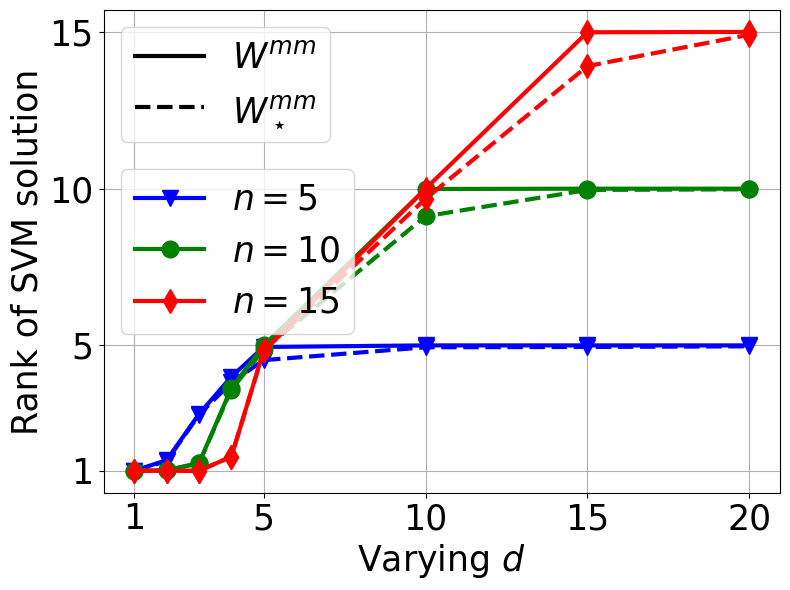

In [4]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.5*height,0.5*height], linestyle=orig_handle[0], color='k', linewidth=3)
        return [l1]

plot_diff_n = True
plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r']
markers = ['v', 'o', 'd']

if plot_diff_n:
    for i in range(len(ns)):
        plt.plot(ds, rank_W[0,i,0].mean(axis=1), color=colors[i], linewidth=3, marker=markers[i], markersize=12, label=rf'$n={ns[i]}$')
        plt.plot(ds, rank_W[1,i,0].mean(axis=1), color=colors[i], linewidth=3, marker=markers[i], markersize=12, linestyle='--')
    plt.yticks([1,5,10,15], fontsize=25)
    legend1 = plt.legend([('-',),('--',)], [r'$W^{mm}$',r'$W^{mm}_\star$'], fontsize=25, loc='upper left', handler_map={tuple: AnyObjectHandler()})
    plt.legend(fontsize=25, loc='center left')
    plt.gca().add_artist(legend1)
else:
    for i in range(len(Ts)):
        plt.plot(ds, rank_W[0,0,i].mean(axis=1), color=colors[i], linewidth=3, marker=markers[i], markersize=12, label=rf'$T={Ts[i]}$')
        plt.plot(ds, rank_W[1,0,i].mean(axis=1), color=colors[i], linewidth=3, marker=markers[i], markersize=12, linestyle='--')
    plt.yticks([1,2,3,4,5], fontsize=25)
    legend1 = plt.legend([('-',),('--',)], [r'$W^{mm}$',r'$W^{mm}_\star$'], fontsize=25, loc='lower right', handler_map={tuple: AnyObjectHandler()})
    plt.legend(fontsize=25, loc='center right')
    plt.gca().add_artist(legend1)

plt.xlabel(r'Varying $d$', fontsize=25)
plt.ylabel(rf'Rank of SVM solution', fontsize=25)
plt.xticks([1,5,10,15,20], fontsize=25)
plt.grid()
plt.tight_layout()
plt.show()